TechCrunch Posts Recommendation
============

I like TechCrunch because I'd like to know about new technology, new startups, initial public offering, merger and acquisition activities. 

The data is downloaded from [TechCrunch](https://techcrunch.com/) website  using Thiago Baldo 's scraper [link](https://github.com/thibalbo/techcrunch-posts-scraper). 
It provides several features for me to create different analyses such as exploratory data analysis, time series, clustering, predictive, segmenting, classification and tons of others. 

Personalized recommender based on the text of the content
--------
"If you posted this article, you might be interested in these articles." -done Oct. 27, 2016

Future
----

- Exploratory data analysis, patterns, insights...
    - Top X authors with the most posts -done Oct. 27, 2016  
    - Lengths of titles and contents
    - Top X categories with the most posts
    - Top X terms posted by the top authors vs. time 

- From bag of words (tfidf) model to Word2Vec [my practice using Word2Vec for IMDb sentiment analysis](https://github.com/yinghsienwu/MachineLearningUdacity/blob/master/mini-projects/Bayes_NLP/Bag_of_words/Word_vectors_p2.ipynb)
1. Build an interactive website 
2. Try to scrape subscribers' metadata (subscriber_id, clicked, opened in email newsletter) [my original code for HackerRank machine learning codesprint: predict email opens](https://github.com/yinghsienwu/Data_challenges/blob/master/Predict_email_opens.ipynb) and create 'labels'
- With labels, I can build a latent factor model. For example, time of the post, how long does it take to read the post, and categories of the post will affect how much you want to read it. [my practice building a latent factor model using Gibbs Sampling for restaurant recommendation](https://github.com/yinghsienwu/RestaurantsRecommender/blob/master/Restaurant_recommendation_system.ipynb)

In [3]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from wordcloud import WordCloud,STOPWORDS
%matplotlib inline
plt.style.use('ggplot')

Load data
-----

In [55]:
df_raw = pd.read_csv("techcrunch_posts.csv")
print(df_raw.shape)

(39115, 11)


In [56]:
df_raw.head(2)

,authors,category,content,date,id,img_src,section,tags,title,topics,url
0,Dale Chang,Startups,\n\nTech investing isn’t what it used to be — ...,2016-10-15,1401293,https://tctechcrunch2011.files.wordpress.com/2...,startups/,data,How startups can use data to grow smarter,NaN,https://techcrunch.com/2016/10/15/how-startups...
1,"Ben Narasin,Jeremy Abelson",Fundings & Exits,\n\nThe IPO market is poised to make an almost...,2016-10-14,1399050,https://tctechcrunch2011.files.wordpress.com/2...,startups/,ipo,"While the IPO market roars back, venture remai...",NaN,https://techcrunch.com/2016/10/14/while-the-ip...


Pre-process data
---------

In [57]:
df=df_raw.copy()
# parse df.authors
df['authors']=df['authors'].apply(lambda x: str(x).split(','))
# parse df.tags and impute NaN 
df['tags']=df['tags'].apply(lambda x: ['No tag'] if str(x)=='NaN' else str(x).split(','))
# parse df.topics
df['topics']=df['topics'].apply(lambda x: str(x).split(','))

In [8]:
# remove data points without content
df['content']=df['content'].fillna(0)
df=df[df.content!=0]
df=df.reset_index(drop=True)

Vectorize content of the posts
-----

In [17]:
import re
import nltk
#nltk.download() #done
from nltk.corpus import stopwords

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [34]:
def To_Words(content):
    """
    Given the content of a post, return a list of meaningful words.
    """
    letters_only = re.sub("[^a-zA-Z]"," ", content)
    words = letters_only.lower().split()
    stops = stopwords.words("english")
    meaningful_words = [w for w in words if not w in stops]
    return(" ".join(meaningful_words))

In [35]:
clean_content=[]
for post in df['content']:
    clean_content.append(To_Words(post)) 

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()
features=tfidf.fit_transform(clean_content)

Build a k-nearest neighbors model
---------------

In [44]:
from sklearn.neighbors import NearestNeighbors
knn=NearestNeighbors(n_neighbors=30, algorithm='brute', metric='cosine')
knn_fit=knn.fit(features)

Construct a simple recommender
--------------

In [102]:
def Recommend_To_User(this_author, k):
    """Find top k articles for this_author"""
    #Find all articles posted by this_author
    ind=[]
    for i in range(len(df)):
        if this_author in df['authors'][i]:
            ind.append(i)
    tmp_df=df.iloc[ind,:]
    
    #Vectorize them
    this_author_content=[]
    for post in tmp_df['content']:
        this_author_content.append(To_Words(post))
        
    #Visualize the author's latest article 
    wordcloud=WordCloud(background_color='black', width=3000, height=2500).generate(this_author_content[0])
    
    #Find indices of the nearest neighbors based on this author's latest article
    neighbors=knn_fit.kneighbors(features[ind[0]])[1].tolist()[0][2:]
    
    #Exclude articles that is authored/co-cuthored by this author
    neighbor_articles= df.iloc[neighbors,:].reset_index(drop=True)
    kept_ind=[]
    for j in range(len(neighbor_articles)):
        if this_author in neighbor_articles['authors'][j]:
            pass
        else:
            kept_ind.append(j)
    rec_articles=neighbor_articles.iloc[kept_ind,:].reset_index(drop=True)
    top_rec_articles=rec_articles.iloc[0:k,:]
    
    # Display result
    print '***'*25
    print 'The latest article of ',this_author,'is featured by the following words'
    plt.figure(1,figsize=(7,7))
    plt.imshow(wordcloud)
    plt.show()
    print '***'*25
    print 'The top ',k,' articles recommdned to ',this_author,' are:'
    for l in range(k):
        print top_rec_articles['title'][l],'by',top_rec_articles['authors'][l][0]
        print top_rec_articles['url'][l]
        

Test the recommendar
------
**Which author should I test first?**

In [73]:
# Find the top20 authors who posted most articles
num_posts_all_authors= df_raw.groupby('authors',as_index=False).id.count()
top20_posts_authors=num_posts_all_authors.sort_values(['id'],ascending=False)[:20]
top20_posts_authors.rename(columns = {'id':'num_posts'}, inplace = True)
top20_posts_authors.head()

,authors,num_posts
890,Sarah Perez,3772
85,Anthony Ha,3232
397,Ingrid Lunden,3026
219,Darrell Etherington,2895
731,Natasha Lomas,2555


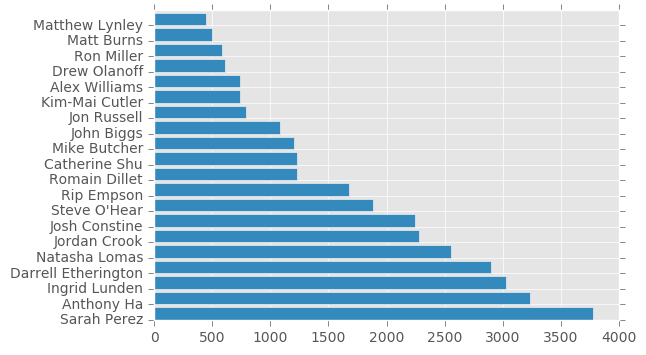

In [112]:
#Visualize top 20 authors with most posts
plt.barh(range(20), top20_posts_authors.num_posts)
plt.yticks(range(20),top20_posts_authors.authors)
plt.show()

**Recommend articles to the top authors**

***************************************************************************
The latest article of  Sarah Perez is featured by the following words


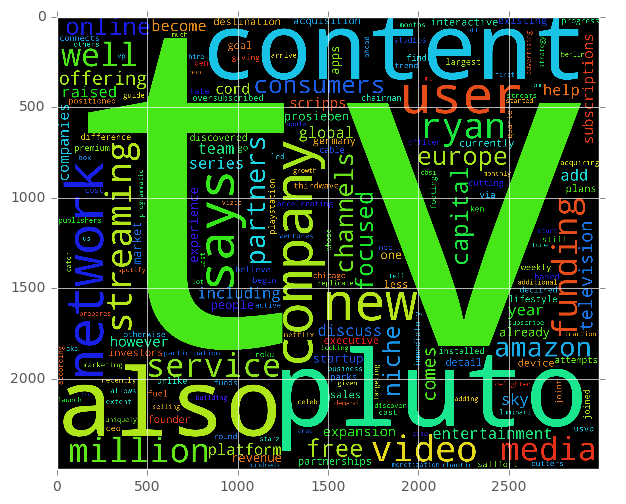

***************************************************************************
The top  5  articles recommdned to  Sarah Perez  are:
Evoke Is A New Induction-Based Vaporizer That Looks And Feels Like An Old-School Pipe by Jordan Crook
https://techcrunch.com/2014/07/16/evoke-is-a-new-induction-based-vaporizer-that-looks-and-feels-like-an-old-school-pipe/
Moniker Looks To Crowdfunding To Create A Custom Guitar Business by John Biggs
https://techcrunch.com/2013/03/28/moniker-is-looking-to-crowdfunding-to-create-a-custom-guitar-business/
Pinterest acquires Instapaper, which will live on as a separate app by Matthew Lynley
https://techcrunch.com/2016/08/23/pinterest-acquires-instapaper-which-will-live-on-as-a-separate-app/
CrowdFlower Co-Founder Lukas Biewald Becomes CEO (Again) by Anthony Ha
https://techcrunch.com/2012/03/22/crowdflower-lukas-biewald-returns/
Naked Labs enters the fitness tech fray with body-scanning mirror by Lora Kolodny
https://techcrunch.com/2016/04/14/naked-labs-enters-t

In [103]:
k=5
author1=top20_posts_authors.values[0][0]
Recommend_To_User(author1,k)

***************************************************************************
The latest article of  Anthony Ha is featured by the following words


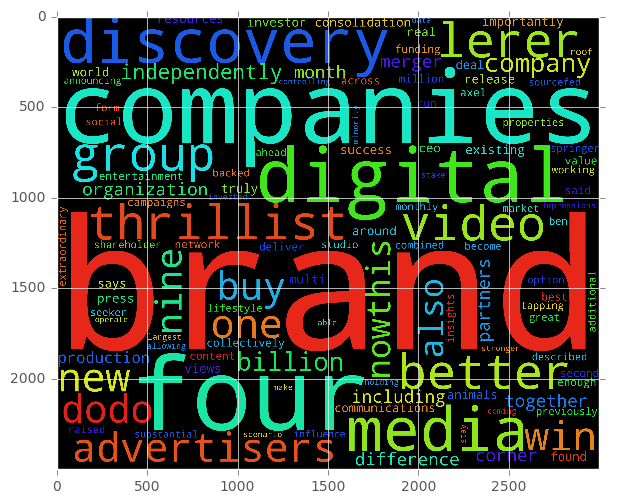

***************************************************************************
The top  5  articles recommdned to  Anthony Ha  are:
On Its 3rd Birthday, The Cloudy OpenStack Is A Marketing Machine, And That’s Just Fine by Alex Williams
https://techcrunch.com/2013/07/24/on-its-3rd-birthday-the-cloudy-openstack-is-a-marketing-machine-and-thats-just-fine/
LinkedIn CEO Talks Evolution: Salesforce Is A Partner Today, Google+ Could Be Competition Tomorrow, And What About Yammer? by Ingrid Lunden
https://techcrunch.com/2013/09/09/linkedin-ceo-talks-evolution-salesforce-is-a-partner-today-google-could-be-a-competitor-tomorrow/
Facebook Mention Tagging Lets Apps Generate FB Notifications And Referral Traffic by Billy Gallagher
https://techcrunch.com/2012/08/21/facebook-mention-tagging-lets-apps-generate-fb-notifications-and-referral-traffic/
Nutmeg Is The Answer To Your Sad, Gif-Free Existence  by Jordan Crook
https://techcrunch.com/2014/06/14/nutmeg-is-the-answer-to-your-sad-gif-free-existence/
T

In [111]:
author2=top20_posts_authors.values[1][0]
Recommend_To_User(author2,k)